## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation ... not yet
3. Testing the metric


In [ ]:
using PyCall
using DataFrames
using Statistics

using Clustering
@pyimport scipy.spatial as sp

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"

cd(wdir)

In [ ]:
## Main program

voname = "test.vot"

data       = read_votable(voname)
df         = filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [4.0,5.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

In [7]:
function _clusters(data , epsilon, leaf , minneigh, mincluster)
    eps = epsilon
    leafsize = leaf
    min_neighbors = minneigh
    min_cluster_size = mincluster

    res = dbscan(data , eps , leafsize = leaf, min_neighbors = minneigh, min_cluster_size=mincluster)
    
    label = Vector{Vector{Int}}()
    
    for cl in res
        indx = cl.core_indices
        append!(indx, cl.boundary_indices) 
        push!(label,indx)
    end
    return(label)
end

## Clustering ..
println("## Starting Clustering ...")

###########################3
eps = 3.0
min_nei = 11
min_cl = 6

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)
println("## dbscan..")
labels = clusters(dftemp.data , eps , 20, min_nei, min_cl)
println("### done ...")



println("## Computing metric ...")
# println(labels)
println("spatial2d")
q2d = metric(dfcart, labels, "spatial2d" , 2.0 , 20.0, 20 )
println(q2d)
println("spatial3d")
q3d = metric(dfcart, labels, "spatial3d" , 5.0 , 20.0, 20 )
println(q3d)
println("velocity")
qv = metric(dfcart, labels, "velocity" , 3.0 , 30.0, 20 )
println(qv)
println("HRD")
qp, qa = metric(dfcart, labels, "HRD" )
println(qp)
println(qa)

indx = labels[10]
npts = []
nlab = 0
for ilab in labels
    nlab += 1
    println("Label:",nlab," - :",length(ilab))
    push!(npts, length(ilab))
end



## Starting Clustering ...
ϵ : 3.0
## dbscan..
### done ...
## Computing metric ...
spatial2d
Any[(0.695809, 0.576484), (0.830026, 0.787194), (1.13487, 0.749366), (0.158903, 0.335865), (0.19356, 0.353885), (0.586569, 0.688618), (1.18696, 0.720131), (0.413283, 0.572576), (0.50287, 0.58211), (1.86736, 1.17705), (0.768351, 0.733958), (0.771013, 0.829433), (0.801823, 0.753612), (1.07325, 0.806663), (0.173287, 0.381314), (0.372736, 0.513739), (0.621227, 0.562117), (0.537528, 0.436512), (0.655263, 0.589491), (0.38712, 0.414239), (0.138629, 0.482328), (0.670268, 0.599255), (0.58068, 0.626058), (0.89872, 0.738658), (0.81156, 0.941057), (0.256986, 0.438184), (0.283148, 0.519844), (0.687936, 0.761551), (0.945155, 0.993436), (0.667662, 0.566981), (0.540134, 0.766696), (1.22688, 0.837372), (0.709008, 0.702535), (0.158903, 0.604711), (0.814787, 0.537784), (0.179176, 0.520456), (0.629391, 0.936024), (0.586569, 1.00598), (0.710815, 0.421928), (0.207944, 0.455361), (0.708209, 0.422968), (0.49636, 0.74

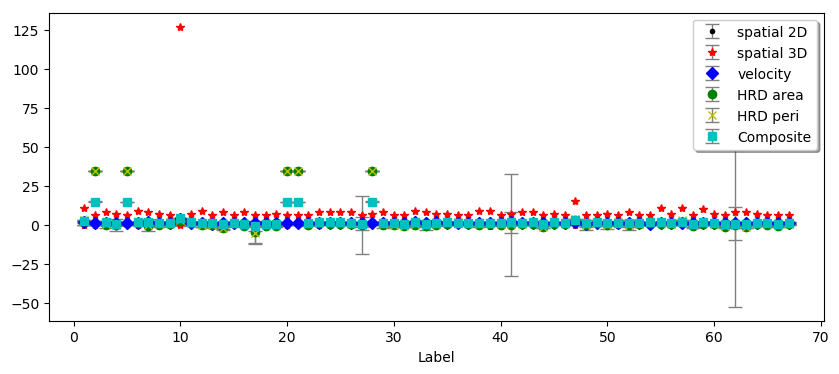

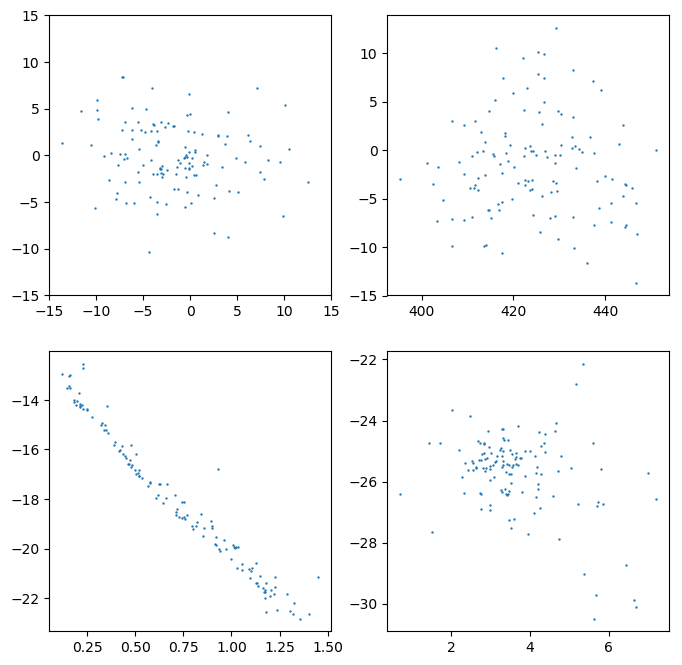

In [9]:
## push Q, Q_st
function pushQ(qc)
    q1  = []
    q1d = []
    for q in qc
        push!(q1,q[1])
        push!(q1d,q[2]/10) 
    end
    return(q1, q1d)
end
    
## metric of the labels
plt.figure(figsize=(10.0,4.0))

xlabel = 1:nlab

qq2d  , qqd2d = pushQ(q2d)
qq3d  , qqd3d = pushQ(q3d)
qqv  , qqdv = pushQ(qv)
qqa  , qqda = pushQ(qa)
qqp  , qqdp = pushQ(qp)


## composite
Qcp = (3.0 .* qq2d .+ qq3d .+ 3.0 .* qqv .+ qqa .+ qqp) ./ 5
Qdcp = (3.0 .* qqd2d .+ qqd3d .+ 3.0 .* qqdv .+ qqda .+ qqdp) ./ 5 


plt.errorbar(xlabel, qq2d, qq2d, label="spatial 2D",fmt=".k", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qq3d, qqd3d, label="spatial 3D",fmt="*r", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqv, qqdv, label="velocity",fmt="Db", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqa, qqda, label="HRD area",fmt="og", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqp, qqdp, label="HRD peri",fmt="xy", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, Qcp, Qdcp, label="Composite",fmt="sc", ecolor="gray", lw=1, capsize=5)
plt.legend(loc="upper right", shadow=true)
plt.xlabel("Label")
plt.show()

plt.plot(xlabel, npts,"*r")
plt.show()

println("N points in red (3D spatial)...")

plt.figure(figsize=(8.0,8.0))

plt.subplot(2, 2, 1 , xlim = [-15,15] , ylim = [-15,15])
x = dfcart.data[2,indx]
y = dfcart.data[3,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 2)
x = dfcart.data[1,indx]
y = dfcart.data[2,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 3)
x = dfcart.data[7,indx]
y = -dfcart.data[6,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 4)
x = dfcart.data[4,indx]
y = -dfcart.data[5,indx]
plt.scatter(x, y , s = 0.5 )


plt.show()